## Particle tracking through a steady-state system with lateral flow boundaries and a refined vertex grid.

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 4 from the MODPATH 7 documentation.

This notebook demonstrates a steady-state MODFLOW 6 simulation using a quadpatch DISV grid with an irregular domain and a large number of inactive cells. Particles are tracked backwards from terminating locations, including a pair of wells in a locally-refined region of the grid and constant-head cells along the grid's right side, to release locations along the left border of the grid's active region. Injection wells along the left-hand border are used to generate boundary flows.

### Problem setup

First import dependencies.

In [55]:
import os
import sys
from warnings import warn
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, LineString
import flopy
from flopy.utils.gridintersect import GridIntersect
import numpy as np
import pandas as pd
from pathlib import Path

try:
    # append the common/ subdirectory to the system path
    # (assumes running one level down from project root)
    sys.path.append(os.path.join("..", "common"))
    import config

    buildModel = config.buildModel
    writeModel = config.writeModel
    runModel = config.runModel
    plotModel = config.plotModel
    plotSave = config.plotSave
    base_ws = config.base_ws
    timeit = config.timeit
except:
    warn(f"Failed to import config")
    # default settings
    buildModel = True
    writeModel = True
    runModel = True
    plotModel = True
    plotSave = False
    base_ws = Path("../examples")

    def timeit(func):
        return func

Define workspace paths and model/file-names.

In [56]:
sim_name = "mp7-p04"
example_name = "ex-prt-" + sim_name
gwf_name = sim_name + "-gwf"
prt_name = sim_name + "-prt"
mp7_name = sim_name + "-mp7"

sim_ws = base_ws / example_name
gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"

gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

headfile = f"{gwf_name}.hds"
headfile_bkwd = f"{gwf_name}_bkwd.hds"
budgetfile = f"{gwf_name}.cbb"
budgetfile_bkwd = f"{gwf_name}_bkwd.bud"
trackfile_prt = f"{prt_name}.trk"
trackcsvfile_prt = f"{prt_name}.trk.csv"
budgetfile_prt = f"{prt_name}.cbb"
pathlinefile_mp7 = f"{mp7_name}.mppth"

### Grid refinement

[GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) can be used to create a quadpatch grid with a refined region in the upper left quadrant.

We will create a grid with 3 refinement levels, all nearly but not perfectly rectangular: a 500x500 area is carved out of the corners of the rectangle for each level. To form each region's polygon we combine 5 rectangles.

Create the top-level grid discretization.

In [57]:
nlay, nrow, ncol = 1, 21, 26
delr = delc = 500.0
top = 100.0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Refine the grid. Create a Gridgen object from the base grid, then add refinement features.

In [58]:
from flopy.utils.gridgen import Gridgen

# create Gridgen workspace
gridgen_ws = sim_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws=gridgen_ws, exe_name="gridgen")

# add polygon for each refinement level
outer_polygon = [
    [
        (2500, 6000),
        (2500, 9500),
        (3000, 9500),
        (3000, 10000),
        (6000, 10000),
        (6000, 9500),
        (6500, 9500),
        (6500, 6000),
        (6000, 6000),
        (6000, 5500),
        (3000, 5500),
        (3000, 6000),
        (2500, 6000),
    ]
]
g.add_refinement_features([outer_polygon], "polygon", 1, range(nlay))
refshp0 = gridgen_ws / "rf0"

middle_polygon = [
    [
        (3000, 6500),
        (3000, 9000),
        (3500, 9000),
        (3500, 9500),
        (5500, 9500),
        (5500, 9000),
        (6000, 9000),
        (6000, 6500),
        (5500, 6500),
        (5500, 6000),
        (3500, 6000),
        (3500, 6500),
        (3000, 6500),
    ]
]
g.add_refinement_features([middle_polygon], "polygon", 2, range(nlay))
refshp1 = gridgen_ws / "rf1"

inner_polygon = [
    [
        (3500, 7000),
        (3500, 8500),
        (4000, 8500),
        (4000, 9000),
        (5000, 9000),
        (5000, 8500),
        (5500, 8500),
        (5500, 7000),
        (5000, 7000),
        (5000, 6500),
        (4000, 6500),
        (4000, 7000),
        (3500, 7000),
    ]
]
g.add_refinement_features([inner_polygon], "polygon", 3, range(nlay))
refshp2 = gridgen_ws / "rf2"

Build the grid and plot it with refinement levels superimposed.

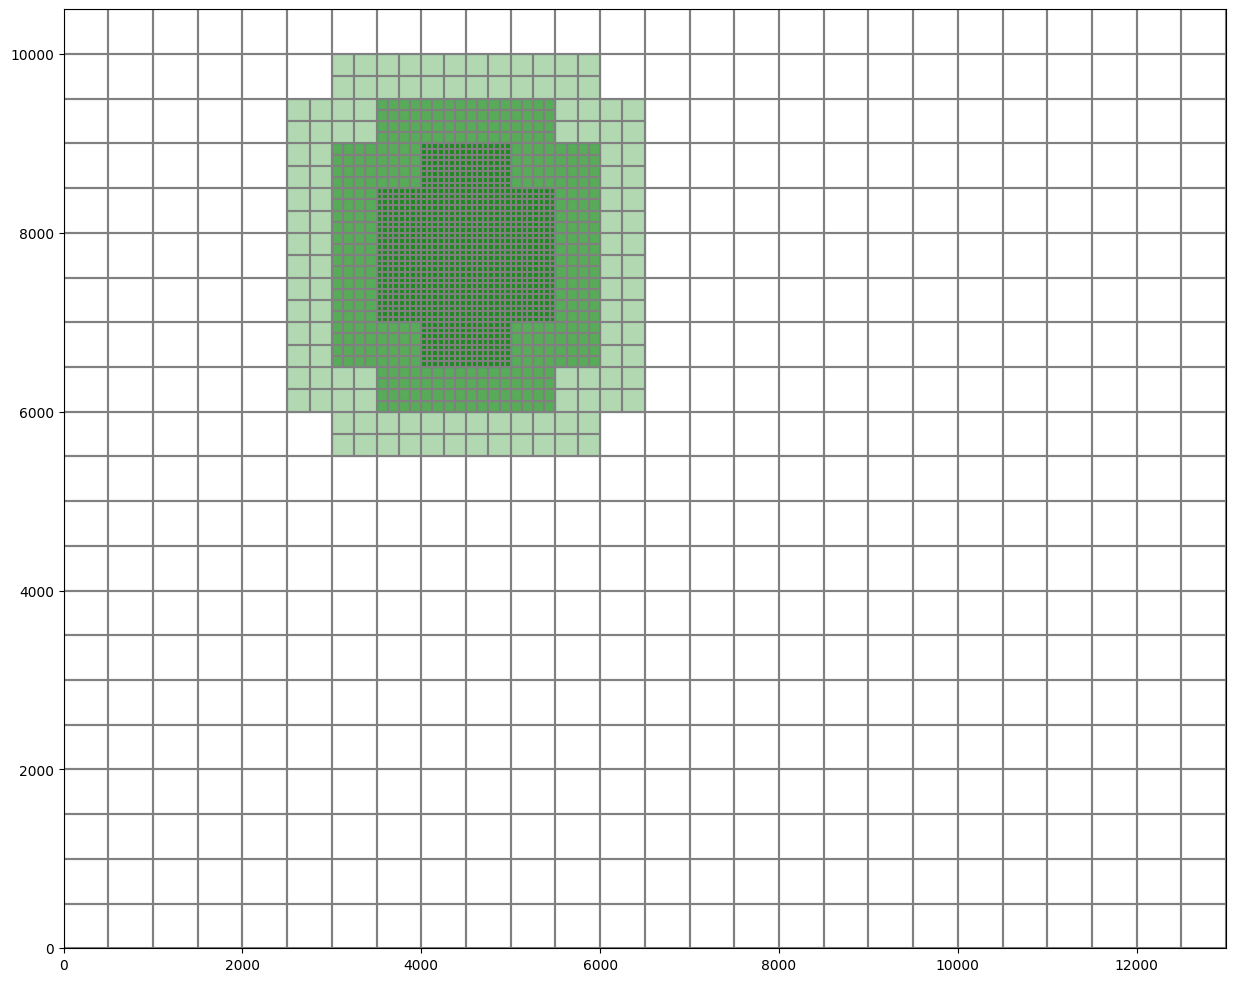

In [59]:
g.build(verbose=False)
grid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)

flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.3)
flopy.plot.plot_shapefile(refshp1, ax=ax, facecolor="green", alpha=0.5)
flopy.plot.plot_shapefile(str(refshp2), ax=ax, facecolor="green", alpha=0.7)

We are now ready to set up groundwater flow and particle tracking models.

Define shared variables, including discretization parameters, idomain, and porosity.

In [60]:
porosity = 0.1
nper = 1
tdis_rc = [(10000, 1, 1.0)]
# fmt: off
idomain = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0
]
# fmt: on
disv_props = g.get_gridprops_disv()

# from pprint import pprint
# pprint(idomain, compact=True)

Define well locations and flows.

In [61]:
wells = [
    # negative q: discharge
    (0, 861, -30000.0, 0, -1),
    (0, 891, -30000.0, 0, -1),
    # positive q: injection
    (0, 1959, 10000.0, 1, 4),
    (0, 1932, 10000.0, 3, 3),
    (0, 1931, 10000.0, 3, 3),
    (0, 1930, 5000.0, 1, 4),
    (0, 1930, 5000.0, 3, 3),
    (0, 1903, 5000.0, 1, 4),
    (0, 1903, 5000.0, 3, 3),
    (0, 1876, 10000.0, 3, 3),
    (0, 1875, 10000.0, 3, 3),
    (0, 1874, 5000.0, 1, 4),
    (0, 1874, 5000.0, 3, 3),
    (0, 1847, 10000.0, 3, 3),
    (0, 1846, 10000.0, 3, 3),
    (0, 1845, 5000.0, 1, 4),
    (0, 1845, 5000.0, 3, 3),
    (0, 1818, 5000.0, 1, 4),
    (0, 1818, 5000.0, 3, 3),
    (0, 1792, 10000.0, 1, 4),
    (0, 1766, 10000.0, 1, 4),
    (0, 1740, 5000.0, 1, 4),
    (0, 1740, 5000.0, 4, 1),
    (0, 1715, 5000.0, 1, 4),
    (0, 1715, 5000.0, 4, 1),
    (0, 1690, 10000.0, 1, 4),
    (0, 1646, 5000.0, 1, 4),
    (0, 1646, 5000.0, 4, 1),
    (0, 1549, 5000.0, 1, 4),
    (0, 1549, 5000.0, 4, 1),
    (0, 1332, 5000.0, 4, 1),
    (0, 1332, 5000.0, 1, 5),
    (0, 1021, 2500.0, 1, 4),
    (0, 1021, 2500.0, 4, 1),
    (0, 1020, 5000.0, 1, 5),
    (0, 708, 2500.0, 1, 5),
    (0, 708, 2500.0, 4, 1),
    (0, 711, 625.0, 1, 4),
    (0, 711, 625.0, 4, 1),
    (0, 710, 625.0, 1, 4),
    (0, 710, 625.0, 4, 1),
    (0, 409, 1250.0, 1, 4),
    (0, 407, 625.0, 1, 4),
    (0, 407, 625.0, 4, 1),
    (0, 402, 625.0, 1, 5),
    (0, 402, 625.0, 4, 1),
    (0, 413, 1250.0, 1, 4),
    (0, 411, 1250.0, 1, 4),
    (0, 203, 1250.0, 1, 5),
    (0, 203, 1250.0, 4, 1),
    (0, 202, 1250.0, 1, 4),
    (0, 202, 1250.0, 4, 1),
    (0, 199, 2500.0, 1, 4),
    (0, 197, 1250.0, 1, 4),
    (0, 197, 1250.0, 4, 1),
    (0, 96, 2500.0, 1, 4),
    (0, 96, 2500.0, 4, 1),
    (0, 98, 1250.0, 1, 4),
    (0, 101, 1250.0, 1, 4),
    (0, 101, 1250.0, 4, 1),
    (0, 100, 1250.0, 1, 4),
    (0, 100, 1250.0, 4, 1),
    (0, 43, 2500.0, 1, 5),
    (0, 43, 2500.0, 4, 1),
    (0, 44, 2500.0, 1, 4),
    (0, 44, 2500.0, 4, 1),
    (0, 45, 5000.0, 4, 1),
    (0, 10, 10000.0, 1, 5),
]

assert len(wells) == 68

Define a function to build the groundwater flow model.

In [62]:
def build_gwf():
    print("Building GWF model")

    # simulation
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=gwf_ws, exe_name="mf6", version="mf6"
    )

    # temporal discretization
    tdis = flopy.mf6.ModflowTdis(sim, time_units="days", nper=nper, perioddata=tdis_rc)

    # iterative model solver
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-4,
        outer_maximum=100,
        inner_dvclose=1e-5,
        under_relaxation_theta=0,
        under_relaxation_kappa=0,
        under_relaxation_gamma=0,
        under_relaxation_momentum=0,
        linear_acceleration="BICGSTAB",
        relaxation_factor=0.99,
        number_orthogonalizations=2,
    )

    # groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=gwf_name, model_nam_file=f"{sim_name}.nam", save_flows=True
    )

    # grid discretization
    disv = flopy.mf6.ModflowGwfdisv(
        gwf, length_units="feet", idomain=idomain, **disv_props
    )

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=150.0)

    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf,
        maxbound=len(wells),
        auxiliary=["IFACE", "IFLOWFACE"],
        save_flows=True,
        stress_period_data={0: wells},
    )

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=True,
        save_flows=True,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=[0],
        k=[50],
    )

    # constant head boundary (period, node number, head)
    chd_bound = [
        (0, 1327, 150.0),
        (0, 1545, 150.0),
        (0, 1643, 150.0),
        (0, 1687, 150.0),
        (0, 1713, 150.0),
    ]
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        pname="chd",
        save_flows=True,
        stress_period_data=chd_bound,
        # auxiliary=["IFLOWFACE"]
    )

    # output control
    budget_file = f"{gwf_name}.cbb"
    head_file = f"{gwf_name}.hds"
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        pname="oc",
        budget_filerecord=[budget_file],
        head_filerecord=[head_file],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim

Next we can define the particle-tracking model. This example problem uses a reverse-tracking model, in which termination and release zones are swapped: we "release" (terminate) particles in the constant head boundary on the grid's right edge and the two pumping wells, and track them backwards to "termination" (release) locations at the wells along the left boundary of the active domain.

Define particle release locations, initially in the representation for MODPATH 7 particle input style 1.

In [63]:
# define particles in MODPATH 7 input style 1
# each particle is a tuple (node number, localx, localy, localz)
rpts = [
    (1327, 0.000, 0.125, 0.500),
    (1327, 0.000, 0.375, 0.500),
    (1327, 0.000, 0.625, 0.500),
    (1327, 0.000, 0.875, 0.500),
    (1545, 0.000, 0.125, 0.500),
    (1545, 0.000, 0.375, 0.500),
    (1545, 0.000, 0.625, 0.500),
    (1545, 0.000, 0.875, 0.500),
    (1643, 0.000, 0.125, 0.500),
    (1643, 0.000, 0.375, 0.500),
    (1643, 0.000, 0.625, 0.500),
    (1643, 0.000, 0.875, 0.500),
    (1687, 0.000, 0.125, 0.500),
    (1687, 0.000, 0.375, 0.500),
    (1687, 0.000, 0.625, 0.500),
    (1687, 0.000, 0.875, 0.500),
    (1713, 0.000, 0.125, 0.500),
    (1713, 0.000, 0.375, 0.500),
    (1713, 0.000, 0.625, 0.500),
    (1713, 0.000, 0.875, 0.500),
    (861, 0.000, 0.125, 0.500),
    (861, 0.000, 0.375, 0.500),
    (861, 0.000, 0.625, 0.500),
    (861, 0.000, 0.875, 0.500),
    (861, 1.000, 0.125, 0.500),
    (861, 1.000, 0.375, 0.500),
    (861, 1.000, 0.625, 0.500),
    (861, 1.000, 0.875, 0.500),
    (861, 0.125, 0.000, 0.500),
    (861, 0.375, 0.000, 0.500),
    (861, 0.625, 0.000, 0.500),
    (861, 0.875, 0.000, 0.500),
    (861, 0.125, 1.000, 0.500),
    (861, 0.375, 1.000, 0.500),
    (861, 0.625, 1.000, 0.500),
    (861, 0.875, 1.000, 0.500),
    (891, 0.000, 0.125, 0.500),
    (891, 0.000, 0.375, 0.500),
    (891, 0.000, 0.625, 0.500),
    (891, 0.000, 0.875, 0.500),
    (891, 1.000, 0.125, 0.500),
    (891, 1.000, 0.375, 0.500),
    (891, 1.000, 0.625, 0.500),
    (891, 1.000, 0.875, 0.500),
    (891, 0.125, 0.000, 0.500),
    (891, 0.375, 0.000, 0.500),
    (891, 0.625, 0.000, 0.500),
    (891, 0.875, 0.000, 0.500),
    (891, 0.125, 1.000, 0.500),
    (891, 0.375, 1.000, 0.500),
    (891, 0.625, 1.000, 0.500),
    (891, 0.875, 1.000, 0.500),
]

For vertex grids, the MODFLOW 6 PRT model's PRP (particle release point) package expects initial particle locations as tuples `(irpt, (k, j), x, y, z)`, where `irpt` is the release point index, `k` and `j` are the layer and cell indices, respectively, and `xyz` are coordinates. While MODPATH 7 input style 1 expects local coordinates, PRT expects global coordinates. The user must guarantee that release point coordinates fall within the cell with the given ID.

FloPy's `ParticleData` provides a `to_prp()` utility method (a generator) for conversion to PRT particle release point (PRP) package input data.

In [64]:
particle_data = flopy.modpath.ParticleData(
    partlocs=[p[0] for p in rpts],
    structured=False,
    localx=[p[1] for p in rpts],
    localy=[p[2] for p in rpts],
    localz=[p[3] for p in rpts],
    timeoffset=0,
    drape=0,
)
prp_pkg_data = list(particle_data.to_prp(grid))

Define a function to build the PRT model/simulation.

In [65]:
def build_prt():
    print("Building PRT model")

    simprt = flopy.mf6.MFSimulation(
        sim_name=prt_name, version="mf6", exe_name="mf6", sim_ws=prt_ws
    )

    flopy.mf6.ModflowTdis(
        simprt, pname="tdis", time_units="DAYS", nper=1, perioddata=[(10000, 1, 1.0)]
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        simprt, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
    )

    # Instantiate the MODFLOW 6 DISV vertex grid discretization
    disv = flopy.mf6.ModflowGwfdisv(prt, idomain=idomain, **disv_props)

    # Instantiate the MODFLOW 6 prt model input package
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp",
        filename="{}_4.prp".format(prt_name),
        nreleasepts=len(prp_pkg_data),
        packagedata=prp_pkg_data,
        perioddata={
            0: ["FIRST"],
        },
    )

    # Instantiate the MODFLOW 6 prt output control package
    budgetfile_prt = "{}.cbb".format(prt_name)
    budget_record = [budgetfile_prt]
    trackfile_prt = "{}.trk".format(prt_name)
    trackcsvfile_prt = "{}.trk.csv".format(prt_name)
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=trackfile_prt,
        trackcsv_filerecord=trackcsvfile_prt,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    flopy.mf6.ModflowPrtfmi(
        prt,
        packagedata=[
            ("GWFHEAD", headfile_bkwd),
            ("GWFBUDGET", budgetfile_bkwd),
        ],
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        simprt,
        pname="ems",
        filename="{}.ems".format(prt_name),
    )
    simprt.register_solution_package(ems, [prt.name])

    return simprt

Define a function to create the MODPATH 7 model/simulation.

In [66]:
def build_mp7(gwf):
    print("Building MP7 model")

    pg = flopy.modpath.ParticleGroup(
        particlegroupname="G1", particledata=particle_data, filename=f"{sim_name}.sloc"
    )

    mp = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=mp7_ws,
    )
    mpbas = flopy.modpath.Modpath7Bas(
        mp,
        porosity=porosity,
    )
    mpsim = flopy.modpath.Modpath7Sim(
        mp,
        simulationtype="pathline",
        trackingdirection="backward",
        budgetoutputoption="summary",
        particlegroups=[pg],
    )

    return mp

-

Define a function to build the three models: MODFLOW 6 GWF, MODFLOW6 PRT, and MODPATH 7.

In [67]:
def build_models():
    gwfsim = build_gwf()
    gwf = gwfsim.get_model(gwf_name)
    return gwfsim, build_prt(), build_mp7(gwf)

Define a function to view the grid and boundary conditions. Also highlight the vertices of well-containing cells which lie on the boundary between coarser- and finer-grained refinement regions (there are 7 of these). Note the disagreement between values of `IFLOWFACE` and `IFACE` for these cells. This is because the cells have 5 polygonal faces.

In [68]:
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


def sort_square_verts(verts):
    """Sort 4 or more points on a square in clockwise order, starting with the top-left point"""

    # sort by y coordinate
    verts.sort(key=lambda v: v[1], reverse=True)

    # separate top and bottom rows
    y0 = verts[0][1]
    t = [v for v in verts if v[1] == y0]
    b = verts[len(t) :]

    # sort top and bottom rows by x coordinate
    t.sort(key=lambda v: v[0])
    b.sort(key=lambda v: v[0])

    # return vertices in clockwise order
    return t + list(reversed(b))


def plot_well_cell_ids(ax):
    xc, yc = grid.get_xcellcenters_for_layer(0), grid.get_ycellcenters_for_layer(0)
    for well in wells:
        nn = well[1]
        x, y = xc[nn], yc[nn]
        ax.annotate(str(nn), (x - 50, y - 50), color="purple")


cells_on_refinement_boundary = [10, 43, 203, 402, 708, 1020, 1332]


def plot_well_vertices_on_refinement_boundary(ax):
    for nn in cells_on_refinement_boundary:
        verts = list(set([tuple(grid.verts[v]) for v in grid.iverts[nn]]))
        verts = [
            v
            for v in verts
            if len([vv for vv in verts if vv[0] == v[0]]) > 2
            or len([vv for vv in verts if vv[1] == v[1]]) > 2
        ]
        for v in verts:
            ax.plot(v[0], v[1], "go")


def plot_well_ifaces(ax):
    ifaces = []
    for well in wells:
        nn = well[1]
        iverts = grid.iverts[nn]

        # sort vertices of well cell in clockwise order
        verts = [tuple(grid.verts[v]) for v in iverts]
        sorted_verts = sort_square_verts(list(set(verts.copy())))

        # reduce vertices to 4 corners of square
        xmax, xmin = max([v[0] for v in sorted_verts]), min(
            [v[0] for v in sorted_verts]
        )
        ymax, ymin = max([v[1] for v in sorted_verts]), min(
            [v[1] for v in sorted_verts]
        )
        sorted_verts = [
            v for v in sorted_verts if v[0] in [xmax, xmin] and v[1] in [ymax, ymin]
        ]

        # define the iface line segment
        iface = well[3]
        if iface == 1:
            p0 = sorted_verts[0]
            p1 = sorted_verts[-1]
        elif iface == 2:
            p0 = sorted_verts[1]
            p1 = sorted_verts[2]
        elif iface == 3:
            p0 = sorted_verts[2]
            p1 = sorted_verts[3]
        elif iface == 4:
            p0 = sorted_verts[0]
            p1 = sorted_verts[1]
        else:
            continue

        ifaces.append([p0, p1])

    lc = LineCollection(ifaces, color="red", lw=4)
    ax.add_collection(lc)


def plot_map_view(ax, gwf):
    # plot map view of grid
    mv = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mv.plot_grid(alpha=0.3)
    mv.plot_ibound()  # inactive cells
    mv.plot_bc("WEL", alpha=0.3)  # wells (red)
    ax.add_patch(  # constant head boundary (blue)
        mpl.patches.Rectangle(
            ((ncol - 1) * delc, (nrow - 6) * delr),
            1000,
            -2500,
            linewidth=5,
            facecolor="blue",
            alpha=0.5,
        )
    )


def plot_inset(ax, gwf):
    # create inset
    axins = ax.inset_axes([-0.76, 0.25, 0.7, 0.9])

    # plot grid features
    plot_map_view(axins, gwf)
    # plot_well_cell_ids(axins)
    plot_well_ifaces(axins)
    plot_well_vertices_on_refinement_boundary(axins)

    # zoom in on refined region of injection well boundary
    axins.set_xlim(2000, 6000)
    axins.set_ylim(6000, 10500)

    # add legend
    legend_elements = [
        mpl.lines.Line2D([0], [0], color="red", lw=4, label="Well IFACEs"),
        mpl.lines.Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            label="Well cell vertices on refinement border",
            markerfacecolor="g",
            markersize=15,
        ),
    ]
    axins.legend(handles=legend_elements)

    # add the inset
    ax.indicate_inset_zoom(axins)


def plot_grid(gwf):
    # setup the plot
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")

    # add plot features
    plot_map_view(ax, gwf)
    plot_well_ifaces(ax)
    plot_inset(ax, gwf)

    # add legend
    ax.legend(
        handles=[
            mpl.patches.Patch(color="red", label="Wells"),
            mpl.patches.Patch(color="blue", label="Constant head boundary"),
        ]
    )

Because this problem tracks particles backwards, we need to reverse the head and budget files after running the groundwater flow model and before running the particle tracking model. Define functions to do this (FloPy has a utility that can do most of the work).

In [69]:
def reverse_budgetfile(fpth, rev_fpth, tdis):
    import flopy.utils.binaryfile as bf

    f = bf.CellBudgetFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)


def reverse_headfile(fpth, rev_fpth, tdis):
    import flopy.utils.binaryfile as bf

    f = bf.HeadFile(fpth, tdis=tdis)
    f.reverse(rev_fpth)


# Define a function to run the models, reversing the GWF model's head and budget output files before running the PRT model.


@timeit
def run_models(gwfsim, prtsim, mp7sim):
    success, buff = gwfsim.run_simulation(silent=True, report=True)
    assert success, f"Failed to run MF6 GWF model."
    for line in buff:
        print(line)

    # tdis is required for output file reversal
    tdis = gwfsim.tdis

    # reverse gwf head and output files (for backwards tracking)
    reverse_headfile(gwf_ws / headfile, prt_ws / headfile_bkwd, tdis)
    reverse_budgetfile(gwf_ws / budgetfile, prt_ws / budgetfile_bkwd, tdis)

    success, buff = prtsim.run_simulation(silent=True, report=True)
    assert success, f"Failed to run MF6 PRT model."
    for line in buff:
        print(line)

    success, buff = mp7sim.run_model(silent=True, report=True)
    assert success, "Failed to run MODPATH 7 model."
    for line in buff:
        print(line)


# Define functions to plot heads and particle paths over the grid, comparing the PRT and MODPATH results.

In [70]:
def plot_pathlines(ax, grid, hd, pl, title):
    ax.set_aspect("equal")
    ax.set_title(title)
    mm = flopy.plot.PlotMapView(modelgrid=grid, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    mm.plot_ibound()
    mm.plot_array(hd, alpha=0.5)
    mm.plot_pathline(pl, layer="all", lw=0.3, colors=["black"])


def plot_results(grid, heads, prtpl, mp7pl):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 14))
    plt.suptitle(
        t="Example 4: Particles tracked backward on a locally refined vertex grid with lateral flow boundaries",
        fontsize=14,
        y=0.7,
    )

    plot_pathlines(axes[0], grid, heads, prtpl, "MODFLOW 6 PRT")
    plot_pathlines(axes[1], grid, heads, mp7pl, "MODPATH 7")

    # for ax in axes:
    #     ax.set_xlim(2000, 6000)
    #     ax.set_ylim(6000, 10500)

Define a function to wrap the entire problem scenario.

In [71]:
def scenario():
    # build models
    gwfsim, prtsim, mp7sim = build_models()

    # plot grid with active domain and boundary conditions
    gwf = gwfsim.get_model(gwf_name)
    plot_grid(gwf)

    # write input files
    gwfsim.write_simulation()
    prtsim.write_simulation()
    mp7sim.write_input()

    if runModel:
        # run models
        run_models(gwfsim, prtsim, mp7sim)

        # extract grid
        grid = gwf.modelgrid

        # load mf6 gwf head results
        hf = flopy.utils.HeadFile(gwf_ws / headfile)
        hds = hf.get_data()

        # load mf6 prt pathline results
        prt_pl = pd.read_csv(prt_ws / trackcsvfile_prt)

        # load mp7 pathline results
        plf = flopy.utils.PathlineFile(mp7_ws / pathlinefile_mp7)
        mp7_pl = pd.DataFrame(
            plf.get_destination_pathline_data(range(grid.nnodes), to_recarray=True)
        )

        # plot results
        plot_results(grid, hds, prt_pl, mp7_pl)

Now run the scenario for example problem 4.

Building GWF model
Building PRT model
Building MP7 model
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mp7-p04-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package wel_0...
    writing package npf...
    writing package chd...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 5 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model mp7-p04-prt...
    writing model name file...
    writing package disv...
    writing package mip...
    writing package prp...
    writing package oc...
    writing package fmi...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                VERSION 6.5.0.dev0+prt (preliminary) 0

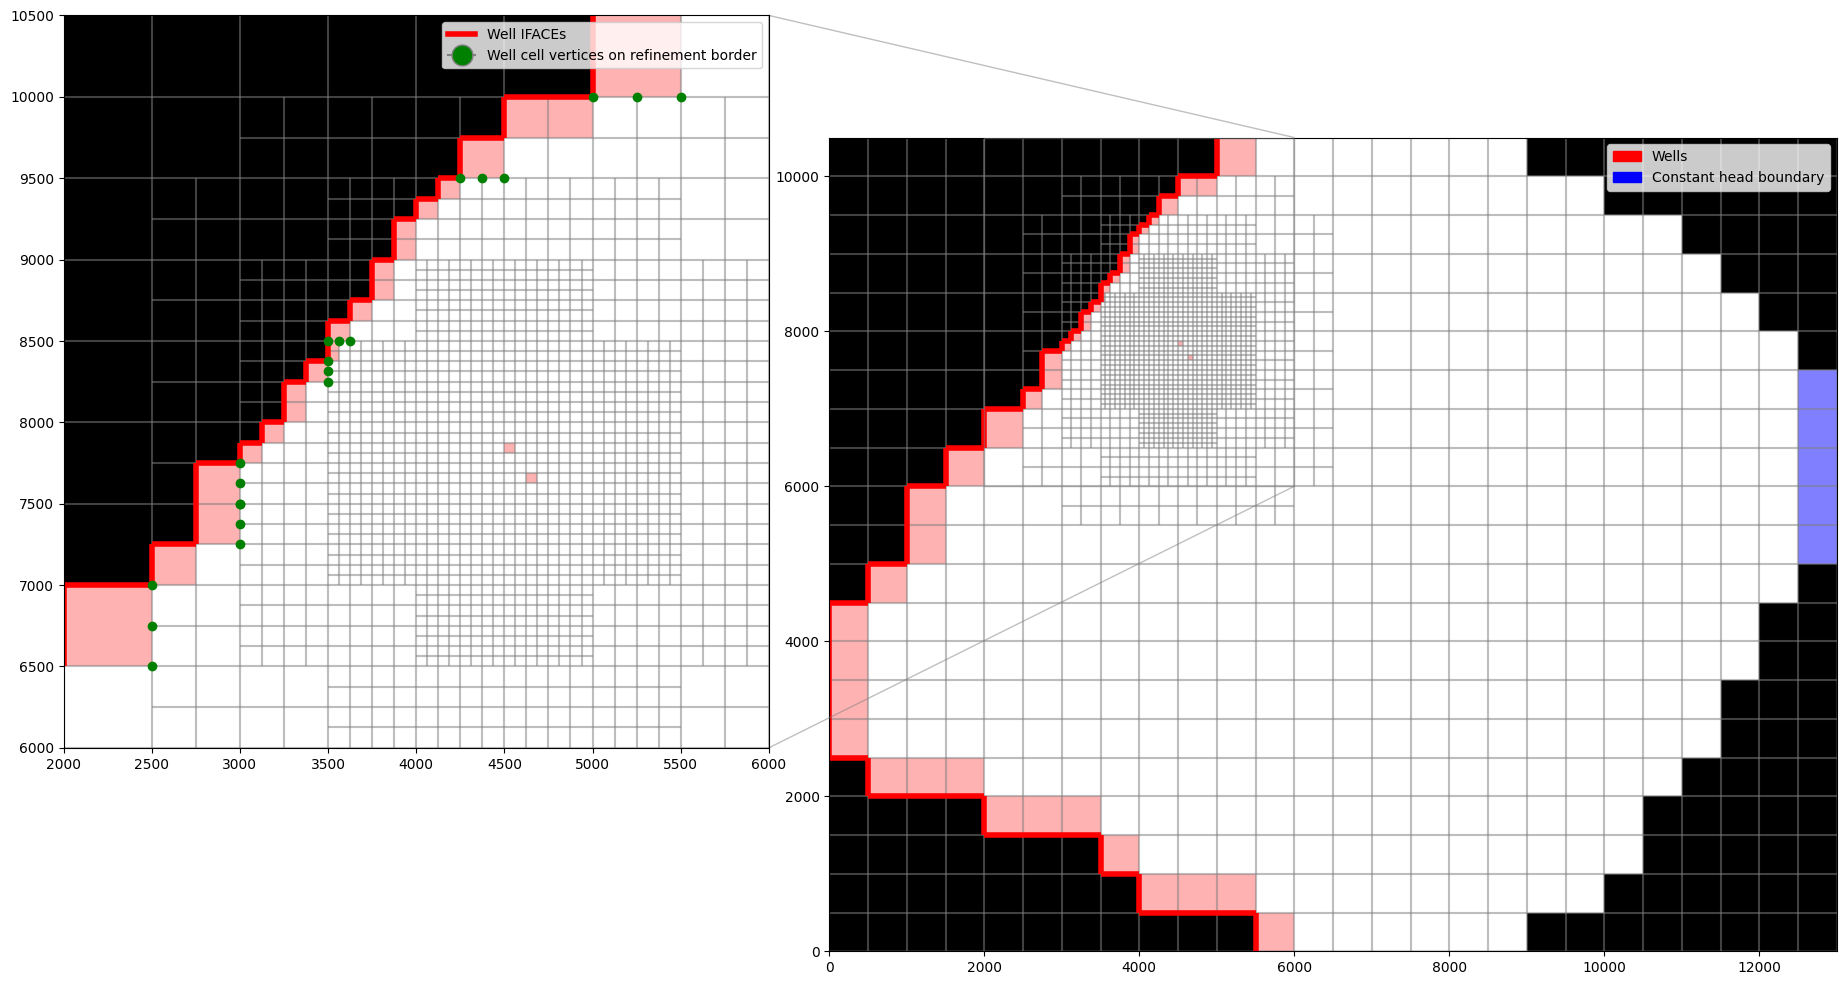

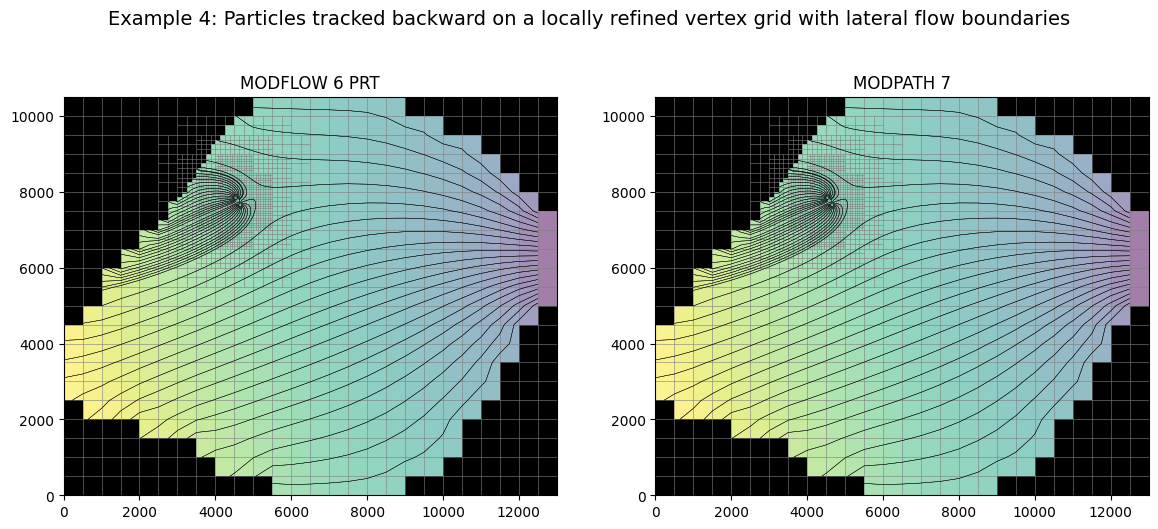

In [72]:
scenario()